## Creating a Logistic regression model based on ACS and HNY dataset to ultiamtely suggest which parcels need affordable housing out of the ones that currently don't have any.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

In [318]:
filter_df = pd.read_csv('filtered_df.csv')
filter_df = filter_df.drop(columns = ['total population','denominator: total population for Hispanic or Latino',
       'total: Hispanic or Latino (any race)', 'Census Tract FIPS 2010'])
filter_df0 = filter_df[(filter_df['is_HNY']==0.0)] # creating a dataframe with only over represented class rows
filter_df0_sample = filter_df0.sample(4000) # Under sampling the over represented class to remove imbalance
filter_df1 = filter_df[(filter_df['is_HNY']==1.0)]
sampled_df = pd.concat([filter_df0_sample, filter_df1]) # concatinating data from both classes
sampled_df1 = sampled_df.sample(frac=1, random_state = 1) # shuffling the data
sampled_df1 = sampled_df1.drop(columns = ['IRRLOTCODE']) 

In [319]:
# Defining features and target variable
xf_df = sampled_df1.iloc[:,:27]
yf_df = pd.DataFrame(sampled_df1.iloc[:,28])

In [320]:
# Creating train test split
Xtr, Xts, ytr, yts = train_test_split(xf_df, yf_df, test_size = 0.2, random_state = 13)

## We need to increase the recall value of the evaluation metric in our model because we want to come up with a list of all parcels which should have affordable housing based on the demographic data of that parcel.

In [361]:
# Making a Logistic Regression model
logist = LogisticRegression(C=1e5,class_weight='unbalanced')
logist.fit(Xtr, ytr)
#yhat = logist.predict(Xts)
yhat = (logist.predict_proba(Xts)[:,1] >= 0.352).astype(float)
yts = np.array(yts)

/Users/utkarshatri/opt/anaconda3/envs/atri/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [362]:
yhat[34]

1.0

In [363]:
# Calculating Confusion Matrix
cm = metrics.confusion_matrix(yts, yhat)

0.6538210320052253


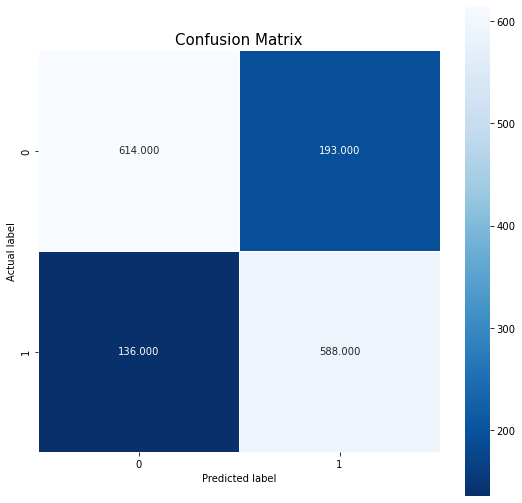

In [366]:
# Calculating score and visualising Confusion matrix
score = logist.score(Xts, yts)
print(score)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);

In [367]:
labels = ['0.0', '1.0']
print(classification_report(yts, yhat, target_names=labels))

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       807
         1.0       0.75      0.81      0.78       724

    accuracy                           0.79      1531
   macro avg       0.79      0.79      0.79      1531
weighted avg       0.79      0.79      0.79      1531



In [386]:
# Using our trained model to make suggestion about where should affordable housing be created.
suggest_df = filter_df0
#suggest_df = filter_df0.sample(600000)
suggest_df_1 = suggest_df.drop(columns = ['IRRLOTCODE'])
x_sug = suggest_df_1.iloc[:,:27]
y_sug = pd.DataFrame(suggest_df_1.iloc[:,28])

In [387]:
yhat_sug = np.array(logist.predict(x_sug))

In [388]:
yhat_sug_1 = yhat_sug[np.where(yhat_sug==1.0)]

In [389]:
print('No. of parcels where we suggest the government to build affordable housing :', len(yhat_sug_1))

No. of parcels where we suggest the government to build affordable housing : 21818


In [391]:
a = np.array(np.where(yhat_sug==1.0))
a = a.tolist()

In [270]:
#yhat_sug_0 = yhat_sug[np.where(yhat_sug==0.0)]

In [19]:
#len(yhat_sug_0)

## Logistic Regression Using PCA

In [393]:
scaler = preprocessing.StandardScaler().fit(xf_df)

In [394]:
xf_df_scaled = scaler.transform(xf_df)

In [470]:
pca = PCA(xf_df_scaled.shape[1])

In [471]:
xf_df_principal = pca.fit_transform(xf_df_scaled)

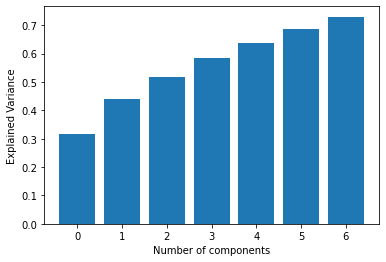

In [472]:
eigenvalues = pca.explained_variance_ratio_
n=7
plt.bar(np.arange(n), eigenvalues[:n].cumsum())
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [473]:
pca1 = PCA(n)
xf_df_principal1 = pca1.fit_transform(xf_df_scaled)

In [474]:
Xtr_pca, Xts_pca, ytr_pca, yts_pca = train_test_split(xf_df_principal1, yf_df, test_size = 0.2, random_state=13)
logist_pca = LogisticRegression(C=1e5,class_weight='unbalanced')
logist_pca.fit(Xtr_pca, ytr_pca)
#yhat_pca = logist_pca.predict(Xts_pca)
yhat_pca = (logist_pca.predict_proba(Xts_pca)[:,1] >= 0.352).astype(float)
yts_pca = np.array(yts_pca)

/Users/utkarshatri/opt/anaconda3/envs/atri/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [475]:
cm = metrics.confusion_matrix(yts_pca, yhat_pca)

0.8184193337687786


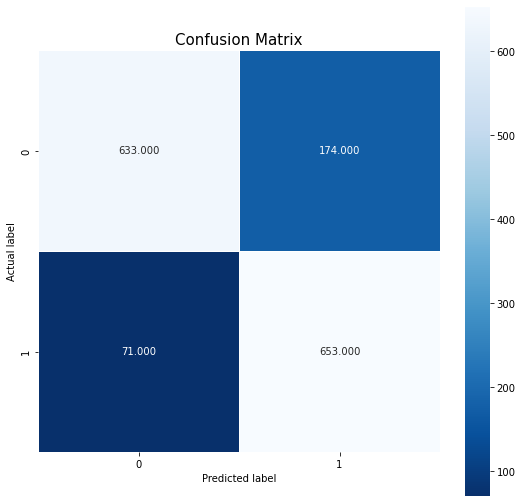

In [476]:
score = logist_pca.score(Xts_pca, yts_pca)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
print(score)

In [477]:
labels = ['0.0', '1.0']
print(classification_report(yts_pca, yhat_pca, target_names=labels))

              precision    recall  f1-score   support

         0.0       0.90      0.78      0.84       807
         1.0       0.79      0.90      0.84       724

    accuracy                           0.84      1531
   macro avg       0.84      0.84      0.84      1531
weighted avg       0.85      0.84      0.84      1531



In [478]:
x_sug_principal = pca1.fit_transform(x_sug)

In [479]:
yhat_sug_pca = np.array(logist_pca.predict(x_sug_principal))

In [480]:
yhat_sug_pca_1 = yhat_sug_pca[np.where(yhat_sug_pca==1.0)]

In [481]:
print('No. of parcels where we suggest the government to build affordable housing :', len(yhat_sug_1))

No. of parcels where we suggest the government to build affordable housing : 21818


In [483]:
p = np.array(np.where(yhat_sug_pca==1.0))
p = p.tolist()
# P is a list of indices where our model recommends affordable housing to be built